In [1]:
import simple_processor
import cv2
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import re
from math import log10, sqrt 
from random import sample 
import os

# import wandb
# wandb.init(project="testings")

In [2]:
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter


class SimpleProcessor:
    """
    Preprocess images using OpenCV processing methods
    """

    def get_grayscale(self, image):
        """
        Convert image to greyscale. Uses COLOR_BGR2GRAY color space conversion code


        Parameters:
        -----------
        - image: dtype('uint8') with 3 channels
            Image loaded with OpenCV imread method or other similar method

        Returns:
        --------
        - greyscale_image: dtype('uint8') with a single channel
            Greyscale image
        """
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    def thresholding(self, image, threshold=127):
        """
        Applies threshold with THRESH_TRUNC type

        Parameters:
        -----------
        - threshold: int, default  to 127

        Returns:
        --------
        - dst: dtype('uint8') with single channel
            Image with applied threshold
        """
        return cv2.threshold(image, threshold, 255, cv2.THRESH_TRUNC)[1]


    def adaptative_thresholding(self, image, maxValue=255):
        """
        Applies adaptative threshold with ADAPTIVE_THRESH_GAUSSIAN_C type

        Parameters:
        -----------
        - maxValue: int, default  to 255
            

        Returns:
        --------
        - dst: dtype('uint8') with single channel
            Image with applied threshold
        """
        return cv2.adaptiveThreshold(image, maxValue, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)
    

    def correct_skew(self, image, delta=1, limit=5):
        """
        Corrects wrong image skew.
        This function is based on Python Skew correction from https://stackoverflow.com/questions/57964634/python-opencv-skew-correction-for-ocr

        Parameters:
        -----------
        - image: dtype('uint8') with 3 channels
            Image loaded with OpenCV imread method or other similar method
        - delta: int, optional
            Possible variation of correction angle
        - limit: int, optional
            A limit for rotation angle

        Returns:
        --------
        - rotated: dtype('uint8') with single channel
            Image with skew corrected based in best angle found by algorithm
        """
        def determine_score(arr, angle):
            data = inter.rotate(arr, angle, reshape=False, order=0)
            histogram = np.sum(data, axis=1)
            score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
            return histogram, score

        scores = []
        angles = np.arange(-limit, limit + delta, delta)
        for angle in angles:
            histogram, score = determine_score(image, angle)
            scores.append(score)

        best_angle = angles[scores.index(max(scores))]

        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
                borderMode=cv2.BORDER_REPLICATE)

        return rotated
    
    def noise_removal(self, image):
        """
        Applies image denoising using Non-local Means Denoising algorithm.

        Parameters:
        -----------
        - image: dtype('uint8') with 3 channels
            Greyscale image
            
        Returns:
        --------
        - dst: dtype('uint8') with single channel
            Denoised image
        """
        return cv2.fastNlMeansDenoising(image, 5, 21, 7)


    def erode(self, image, kernel_size=5, iterations=1):
        """
        Tries to thin image edges using based on a kernel size using CV2 erode method

        Parameters:
        -----------
        - image: dtype('uint8') with 3 channels
            Greyscale image
        - kernel_size: int, optional, default to 5
            Size of image erode kernel
        - iterations: int, optional, default to 1
            Number of kernel iteractions over the image
            
        Returns:
        --------
        - image: dtype('uint8') with single channel
            Image with thin edges
        """
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        return cv2.erode(image, kernel, iterations)


    def preprocess(self, image):
        """
        Executes Simple Processos image correction pipeline in 4 steps:
            1) Binarization;
            2) Noise Removal
            3) Skew Correction
            4) Thinning and Skeletonization

        Parameters:
        -----------
        - image: dtype('uint8') with 3 channels
            Colored Image
            
        Returns:
        --------
        - image: dtype('uint8') with single channel
            Binarized greyscale image with image corrections and noise removal actions applied
        """
        # 1) Binarization
        grayscale = self.get_grayscale(image)
#         thresh = self.thresholding(grayscale)
#         adaptative_thresh = self.adaptative_thresholding(grayscale)

        # 2) Noise Removal
        denoised = self.noise_removal(grayscale)

        # 3) Skew Correction
        corrected_skew_image = self.correct_skew(denoised)
        
        # 4) Thinning and Skeletonization
        ts = self.erode(corrected_skew_image, 1, 1)
        
        return ts

In [3]:
proc = SimpleProcessor()

In [4]:
# wandb login 47eacb1d10f6f89fbfb0c5daffe51783016b402c

In [5]:
paths = glob('./crappy_images/*.jpg')
selected_image = paths[1000]
selected_image = re.sub(r'./crappy_images/', '', selected_image)

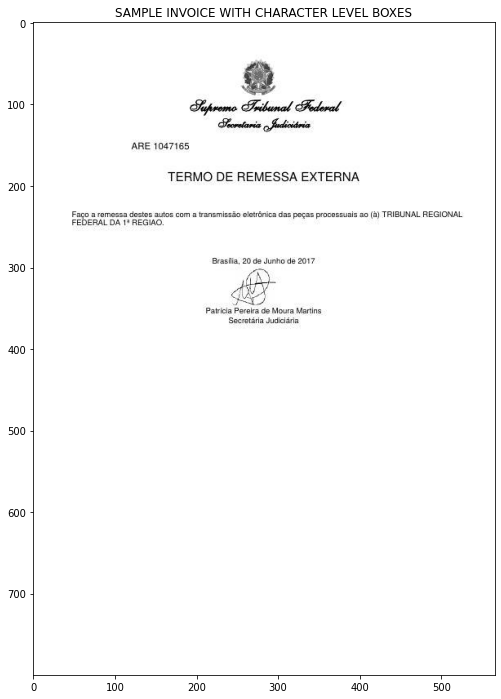

In [6]:
original_image = cv2.imread('./is_ocr_images/' + selected_image)
# original_image = cv2.imread('./2.png')

# original_image = proc.get_grayscale(original_image)

plt.figure(figsize=(16,12))
plt.imshow(original_image, cmap='gray')
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

In [7]:
# sample_crappy_images = sample(paths, 1000)
# image_numbers = list(map(lambda x: re.sub('./crappy_images/', '', x),  sample_crappy_images))
# sample_original_images = []
# image_exists_paths = []
# for index, p in enumerate(image_numbers):
#     orig_path = './is_ocr_images/{}'.format(p)
#     if os.path.exists(orig_path):
#         sample_original_images.append(orig_path)
#         image_exists_paths.append(p)
#     else:
#         sample_crappy_images.pop(index)
        
# print(len(sample_original_images), len(sample_crappy_images))

sample_crappy_images = glob('./cycle_gan/predicted_decrapp_v2_800/crappy/*.jpg')
sample_original_images = glob('./cycle_gan/predicted_decrapp_v2_800/original/*.jpg')
        
print(len(sample_original_images), len(sample_crappy_images))

1000 1000


In [8]:
def mse(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    return mse

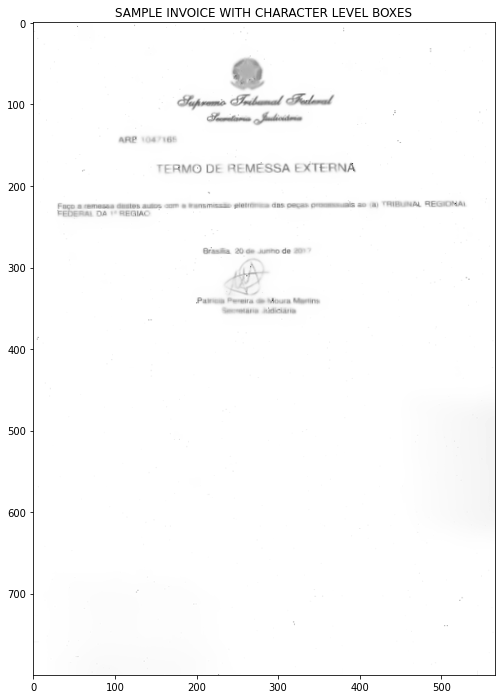

In [9]:
from statistics import median, mean
# image = cv2.imread('./crappy_images/740156_2590157_64.jpg')
image = cv2.imread('./CRAPPY_V2_TEST.png')
image = cv2.imread('./crappy_images/' + selected_image)

# print(np.median(image))

# ret,thresh1 = cv2.threshold(i,127,255,cv2.THRESH_BINARY)
# ret,thresh2 = cv2.threshold(i,127,255,cv2.THRESH_BINARY_INV)
# ret,thresh3 = cv2.threshold(i,127,255,cv2.THRESH_TRUNC)
# ret,thresh4 = cv2.threshold(i,127,255,cv2.THRESH_TOZERO)
# ret,thresh5 = cv2.threshold(i,127,255,cv2.THRESH_TOZERO_INV)
# image = proc.get_grayscale(image)
# image = proc.thresholding(image, 230)
# image = proc.adaptative_thresholding(image)
# image = proc.noise_removal(image)
# image = proc.correct_skew(image)
# erode = proc.erode(image, 2, 1)
# image = cv2.add(image, erode)
# image = proc.thresholding(image, 250)

image = proc.preprocess(image)
# print('MSE BAD IMAGE:', mse(original_image, i))
# print('MSE T BINARY:', mse(original_image, thresh1))
# print('MSE T BINARY INV:', mse(original_image, thresh2))
# print('MSE T TRUNC:', mse(original_image, thresh3))
# print('MSE T TOZERO:', mse(original_image, thresh4))
# print('MSE T TOZERO INV:', mse(original_image, thresh5))
# print('MSE CORRECTED:', mse(original_image, corrected_image))

plt.figure(figsize=(16,12))
plt.imshow(image, cmap='gray')
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

In [10]:
w,h = len(sample_original_images), 6
metric_result = [[0 for x in range(w)] for y in range(h)] 

In [11]:
# for i in range(w):
#     original = cv2.imread(sample_original_images[i], cv2.IMREAD_GRAYSCALE)
#     crappy = cv2.imread(sample_crappy_images[i], cv2.IMREAD_GRAYSCALE)
    
#     # original_mse
#     _0 = mse(original, crappy)
#     metric_result[0][i] = _0
    
#     # BINARY mse
#     ret,thresh1 = cv2.threshold(crappy,127,255,cv2.THRESH_BINARY)
#     _1 = mse(original, thresh1)
#     metric_result[1][i] = _1
    
#     # BINARY INV mse
#     ret,thresh2 = cv2.threshold(crappy,127,255,cv2.THRESH_BINARY_INV)
#     _2 = mse(original, thresh2)
#     metric_result[2][i] = _2
    
    
#     # TRUNC mse
#     ret,thresh3 = cv2.threshold(crappy,127,255,cv2.THRESH_TRUNC)
#     _3 = mse(original, thresh3)
#     metric_result[3][i] = _3
    
    
#     # TOZERO mse
#     ret,thresh4 = cv2.threshold(crappy,127,255,cv2.THRESH_TOZERO)
#     _4 = mse(original, thresh4)
#     metric_result[4][i] = _4
    
    
#     # TOZERO_INV mse
#     ret,thresh5 = cv2.threshold(crappy,127,255,cv2.THRESH_TOZERO_INV)
#     _5 = mse(original, thresh5)
#     metric_result[5][i] = _5    

In [ ]:
# table = wandb.Table(data=metric_result, columns = ["crappy", "binary", "binary_inv", "trunc", "tozero", "tozero_inv"])
# wandb.log({"binarization_comparison" : wandb.plot.line(table, "x", "y")})

def smooth(scalars, weight=.95):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

plt.figure(figsize=(10, 5))
# line 1 points
# plotting the line 1 points 
plt.plot(smooth(metric_result[0]), label = "Crappy")
plt.plot(smooth(metric_result[1]), label = "BINARY")
plt.plot(smooth(metric_result[2]), label = "BINARY INV")
plt.plot(smooth(metric_result[3]), label = "TRUNC")
plt.plot(smooth(metric_result[4]), label = "TOZERO")
plt.plot(smooth(metric_result[5]), label = "TOZERO INV")
plt.xlabel('Image sample')
plt.ylabel('MSE metric')
plt.title('MSE metric over datase sample')
# show a legend on the plot
plt.legend()
# Display a figure.
fig1 = plt.gcf()
# fig1.savefig('smoothed_binarization_test')
plt.show()

## Extração de métricas Rouge-N do pre-processador simples

In [12]:
import pytesseract
from metrics.rouge_metric import RougeMetric
import os
import timeit

In [13]:
# if os.path.exists('./tmp'):
#     os.rmdir('./tmp')
# os.mkdir('./tmp')

In [15]:
preprocess_time = []
metric = RougeMetric()

for index in range(len(sample_original_images[:100])):
#     if index % 100 == 0:
    print('batch: {}'.format(index))
    # get image paths
    original = './cycle_gan/predicted_decrapp_v2_800/original/{}.jpg'.format(index)
    crappy = './cycle_gan/predicted_decrapp_v2_800/crappy/{}.jpg'.format(index)
    
    tic = timeit.default_timer()
    crappy_image = cv2.imread(crappy)
    image = proc.preprocess(crappy_image)
    toc = timeit.default_timer()
    preprocess_time.append(toc - tic)

    # extract text from images
    original_image = cv2.imread(original)
    original_text = pytesseract.image_to_string(original, lang='por+eng')
    
    corrected_text = pytesseract.image_to_string(image, lang='por+eng')
    
    metric.store_data('{}.jpg'.format(index), original_text, corrected_text, '', '', '')

batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
batch: 43
batch: 44
batch: 45
batch: 46
batch: 47
batch: 48
batch: 49
batch: 50
batch: 51
batch: 52
batch: 53
batch: 54
batch: 55
batch: 56
batch: 57
batch: 58
batch: 59
batch: 60
batch: 61
batch: 62
batch: 63
batch: 64
batch: 65
batch: 66
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99


In [16]:
metric.export_data('sample_simple_processor_v2.csv')

Warn: sample_simple_processor_v2.csv exists. Moving it to sample_simple_processor_v2-1607193128.145288.csv


In [17]:
from statistics import mean, median
mean(preprocess_time)

0.34139100541006884

In [ ]:
import csv

c_rouge_1 = []
c_rouge_2 = []
c_rouge_3 = []
c_rouge_4 = []
c_rouge_l = []

s_rouge_1 = []
s_rouge_2 = []
s_rouge_3 = []
s_rouge_4 = []
s_rouge_l = []


indexes = [1, 2, 3, 4, 5, 16, 17, 18, 19, 20]
w,h = 10, 10
rouges = [[0 for x in range(w)] for y in range(h)] 
with open('sample_simple_processor_v2.csv', 'r') as file:
    reader = csv.reader(file, delimiter=';')
    index = 0
    for line in reader:
        if index == 0:
            index += 1
            continue
        for i, m_index in enumerate(indexes):
            if eval(line[m_index])['f'] > 0:
                rouges[i].append(eval(line[m_index])['f'])
            else:
                continue
#         print(eval(line[1])['f'])
        if index == 10:
            break
            
def gt_0 (v):
    print(v)
    return v > .0

list(map(lambda x: mean(x), rouges))